In [382]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from collections import Counter
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [383]:
emb = pd.read_csv("../results/glove/glove_emb_mtg_metabol_100.txt", sep = " ", header = None, index_col = 0)
emb.index = [i.replace(" ", "") for i in emb.index.values]

In [384]:
metabolites = emb.loc[[i[0] != 'K' for i in emb.index.values], :]
genes = emb.loc[[i[0] == 'K' for i in emb.index.values], :]

In [385]:
dist_metabolites = squareform(pdist(metabolites, metric = "euclidean"))
dist_metabolites = pd.DataFrame(dist_metabolites)
dist_metabolites.index = metabolites.index.values
dist_metabolites.columns = metabolites.index.values

In [386]:
dist_genes = squareform(pdist(genes, metric = "euclidean"))
dist_genes = pd.DataFrame(dist_genes)
dist_genes.index = genes.index.values
dist_genes.columns = genes.index.values

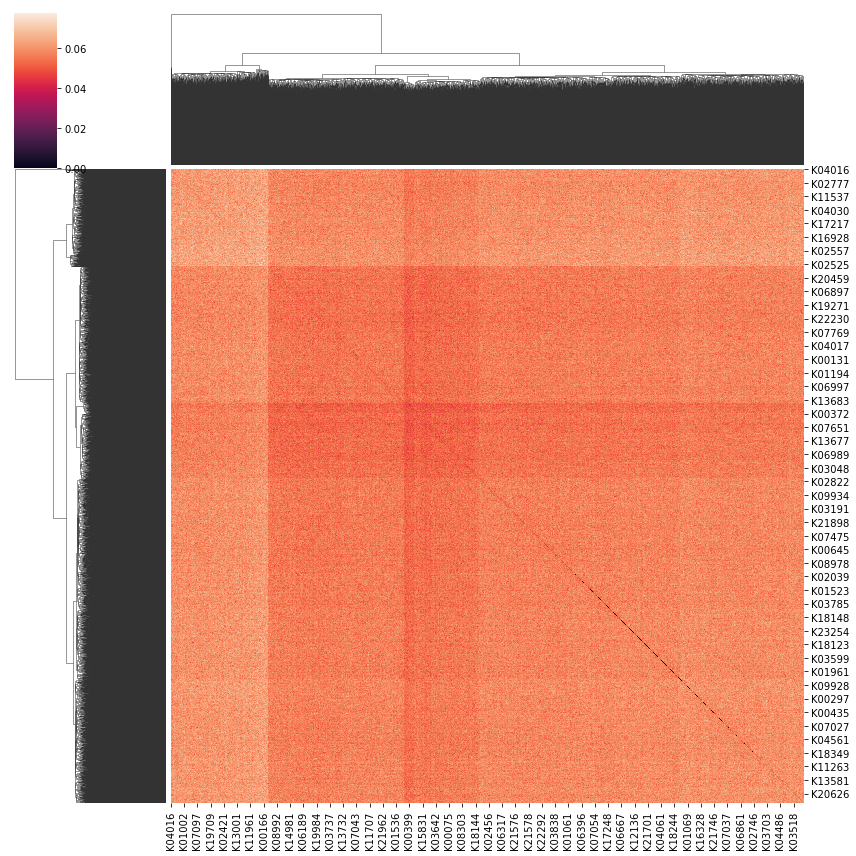

In [277]:
sns.clustermap(dist_genes, figsize = (12,12))

C:\Users\kitikomp\anaconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\kitikomp\anaconda3\lib\site-packages\seaborn\matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


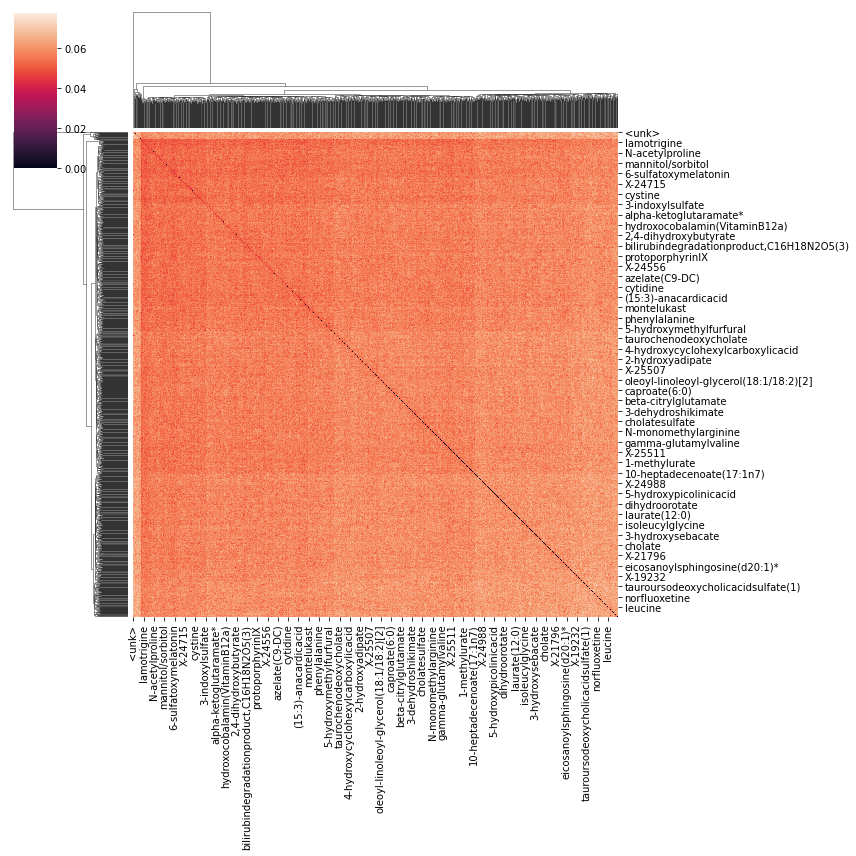

In [338]:
sns.clustermap(dist_metabolites, figsize = (12,12))

In [131]:
row_linkage = hierarchy.linkage(dist_metabolites, method='average')
row_linkage

<ipython-input-131-7a1f7fde24e7>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage = hierarchy.linkage(dist_metabolites, method='average')


array([[2.53000000e+02, 1.13400000e+03, 1.24565435e-01, 2.00000000e+00],
       [2.09000000e+02, 7.30000000e+02, 1.26032282e-01, 2.00000000e+00],
       [7.55000000e+02, 7.63000000e+02, 1.26442690e-01, 2.00000000e+00],
       ...,
       [2.08400000e+03, 2.53000000e+03, 2.20868090e-01, 1.24700000e+03],
       [2.53100000e+03, 2.53200000e+03, 2.36000534e-01, 1.26700000e+03],
       [1.26700000e+03, 2.53300000e+03, 6.05042652e-01, 1.26800000e+03]])

In [176]:
label = hierarchy.cut_tree(row_linkage, n_clusters=3, height=None) 
nice_cluster = metabolites.loc[[i[0]==0 for i in label], :]

In [387]:
metabolite_table = pd.read_csv("../data/metabol/asv_table_nooutliers.txt", sep = "\t")
mapping = pd.read_csv("../data/metabol/mapping_nooutliers2.csv", sep = ",", index_col = 0)
metabolite_table = metabolite_table.loc[ :, mapping.index.values]

In [388]:
metabolite_table.index = [i.replace(" ", "") for i in metabolite_table.index.values]
sums = metabolite_table.loc[nice_cluster.index.values, :].sum(axis = 0)
mapping['sums'] = sums

<AxesSubplot:xlabel='variable_use', ylabel='sums'>

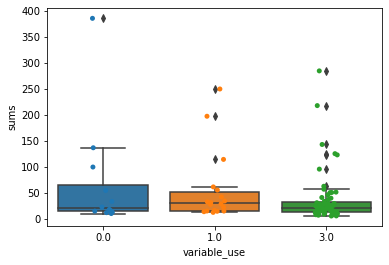

In [389]:
var = "fruit_freq"
variable_values = [3 if i >= 3  else i for i in mapping[var]]
mapping['variable_use'] = variable_values
sns.boxplot(x="variable_use", y = "sums", data = mapping)
sns.stripplot(x="variable_use", y = "sums", data = mapping)

In [334]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
variables = np.array(['fruit_freq', 'vegetable_freq', 'dairy_freq', 
       'nonceliac_sensitivity', 'whole_grain', 'fermented_vegetables', 'dairy',
       'fruit', 'meal_home_prep', 'meal_ready_eat', 'meat', 'olive_oil',
       'seafood', 'sweetened_drink', 'vegetable', 'restaurant', 'sugary_food', 'starchy_food', 'meats_and_seafood', 'bread',
       'dairy_freq', 'fat_oil_freq', 'vegetable_freq', 'fruit_freq'])
for var in variables:
    print(var)
    variable_values = [3 if i >= 3  else i for i in mapping[var]]
    mapping['variable_use'] = variable_values
    grps = pd.unique( mapping['variable_use'].values)
    d_data = {grp:df['sums'][ mapping['variable_use'] == grp] for grp in grps}

    k = len(pd.unique( mapping['variable_use']))  # number of conditions
    N = len( mapping['variable_use'])  # conditions times participants
    n = mapping.groupby(var).size()[0] #Participants in each condition
    f = 'sums ~ variable_use'
    mod = ols(f, data = mapping).fit()
    aov_table = sm.stats.anova_lm(mod, typ = 2)
    print(aov_table)

fruit_freq
                     sum_sq    df         F    PR(>F)
variable_use   13195.822295   1.0  3.415825  0.067822
Residual      351546.023667  91.0       NaN       NaN
vegetable_freq
                     sum_sq    df        F    PR(>F)
variable_use    2889.528644   1.0  0.72667  0.396203
Residual      361852.317318  91.0      NaN       NaN
dairy_freq
                     sum_sq    df         F    PR(>F)
variable_use    2507.652135   1.0  0.629969  0.429431
Residual      362234.193827  91.0       NaN       NaN
nonceliac_sensitivity
                     sum_sq     df         F    PR(>F)
variable_use    5440.681861    1.0  1.488313  0.225348
Residual      365560.399507  100.0       NaN       NaN
whole_grain
                     sum_sq     df         F    PR(>F)
variable_use   15716.027765    1.0  4.423498  0.037957
Residual      355285.053603  100.0       NaN       NaN
fermented_vegetables
                     sum_sq     df         F    PR(>F)
variable_use      39.670347    1.0  0.01

Ttest_indResult(statistic=-1.0018033574187528, pvalue=0.3178377409018666)
Ttest_indResult(statistic=-0.3625885117861047, pvalue=0.7173548735079915)
Ttest_indResult(statistic=0.20899598297239871, pvalue=0.8346972571958835)
Ttest_indResult(statistic=0.42369331702024193, pvalue=0.6723157998834175)
Ttest_indResult(statistic=1.4168215630820187, pvalue=0.15833334423582054)
Ttest_indResult(statistic=0.3937026164698778, pvalue=0.6942854159524716)
Ttest_indResult(statistic=-0.6279380717885985, pvalue=0.5308725350127179)
Ttest_indResult(statistic=0.135094765329246, pvalue=0.8926940010775702)
Ttest_indResult(statistic=-0.5503417759986851, pvalue=0.5827948665846259)
Ttest_indResult(statistic=-1.285943842130425, pvalue=0.20018115910100062)
Ttest_indResult(statistic=-1.1792583552394194, pvalue=0.23991454142660681)
Ttest_indResult(statistic=1.711451922650534, pvalue=0.08878989030727306)
Ttest_indResult(statistic=-0.7576157651805694, pvalue=0.44971175047686573)
Ttest_indResult(statistic=0.762940148198

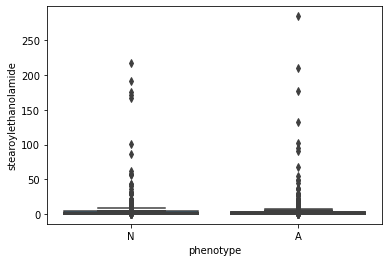

In [274]:
for i in np.arange(20):
    df = metabolite_table.loc[nice_cluster.index.values, :].transpose()
    df['phenotype'] = mapping.phenotype.values
    sns.boxplot(x = "phenotype", y = df.columns[i], data = df)
    print(ttest_ind(df.loc[df.phenotype == 'A', df.columns[i]], df.loc[df.phenotype == 'N', df.columns[i]]))

In [ ]:
dist_nice = squareform(pdist(df, metric = "braycurtis"))
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
print(pca.explained_variance_ratio_)
projected = pca.fit_transform(df)
df.color = ['red' if i == "A" else "blue" for i in df.phenotype]
plt.scatter(projected[:,0], projected[:,1], c = df.color)

from skbio.stats.ordination import pcoa
df['phenotype'] = mapping.phenotype
p = pcoa(dist_nice)
df['pc1']= p.samples.iloc[:, 0].values
df['pc2']= p.samples.iloc[:, 1].values
sns.scatterplot("pc1", "pc2", data = df, hue = "phenotype")

# Classifier

In [390]:
metabolites = metabolites.loc[metabolites.index.values!= "<unk>", :]

In [392]:
metabolite_counts = metabolite_table.transpose().loc[:, metabolites.index.values]
embedded = metabolite_counts.dot(metabolites)

In [393]:
mapping = mapping.loc[metabolite_counts.index.values, :]

In [413]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

In [423]:
table = metabolite_table.transpose()
gss = GroupShuffleSplit(n_splits=10, train_size=.7, random_state=42)
for train_inds, test_inds in gss.split(table, mapping.phenotype, mapping.familyID):
    X_train = table.iloc[train_inds, :]
    X_test = table.iloc[test_inds, :]
    y_train = mapping.phenotype[train_inds]
    y_test = mapping.phenotype[test_inds]
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    print(np.sum(clf.predict(X_test) == y_test) / len(y_test))

0.34375
0.46875
0.4375
0.5333333333333333
0.5483870967741935
0.6774193548387096
0.41935483870967744
0.5483870967741935
0.4375
0.4666666666666667
